In [54]:
### This notebook demonstrates how to correctly load and visualize the preprocessed sway data.

# Dataset hierarchy is managed as follows:
# data/sway61769/dataset61769.txt                                 ----> a list of all the video folder names
#               /sway61769/video_folder_1/images/*.jpg            ----> all image files
#                                        /intrinsics.npy
#                                        /extrinsics.npy
#                                        /bbox.npy
#                                        /wspace_poses3d.npy      ----> w-space 3d poses that are consistent with h36m coordinates
#                                        /cspace-poses3d.npy      ----> c-space 3d poses that are consistent with h36m coordinates "in root-relative space"
#                                        /keypts2d.json
#               /sway61769/video_folder_2
#               /sway61769/video_folder_3
#               /sway61769/video_folder_4



In [55]:
import os
import json
import torch
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from numpy.linalg import inv


In [56]:
### IMPORTANT!!! Joint order information
n_joints = 22
smpljoint_order = ["hips",
                   "left_hip",
                   "right_hip",
                   "spine",
                   "left_knee",
                   "right_knee",
                   "spine1",
                   "left_ankle",
                   "right_ankle",
                   "spine2",
                   "left_toe_base",
                   "right_toe_base",
                   "neck",
                   "left_shoulder",
                   "right_shoulder",
                   "head",
                   "left_upperarm",
                   "right_upperarm",
                   "left_elbow",
                   "right_elbow",
                   "left_wrist",
                   "right_wrist",
                   ]

### These are the joints I used to match the joint order of the h36m prediction output in my IK visualizer. You might need further confirmation when loading them to METRO
smpl_7joints_indices = [0, 15, 17, 19, 21, 16, 18, 20]

### 2D keypoint order. It follows openpose format. You might need it later for 2Ddataset
kpt2d_order = ["nose",
               "neck",
               "r_shoulder",
               "r_elbow",
               "r_hand",
               "l_shoulder",
               "l_elbow",
               "l_hand",
               "pelvis",
               "r_hips",
               "r_knee",
               "r_ankle",
               "l_hips",
               "l_knee",
               "l_ankle",
               "r_eye",
               "l_eye",
               "r_ear",
               "l_ear",
               "l_toe",
               "l_toe_end",
               "l_ankle_end",
               "r_toe",
               "r_toe_end",
               "r_ankle_end",
               ]

In [57]:
sway_folder = "/home/jovyan/data/sway61769"
root = f"{sway_folder}/sway61769"

### Get all video folder names. Don't us os.listdir(root) because it is too slow
with open(f"{sway_folder}/dataset61769.txt", "r") as f:
    vidnames = [line.strip() for line in f.readlines()]

In [58]:
len(vidnames)

61735

In [59]:
### Load all annotations from a video folder

def load_all_annotations_from_folder(folderpath):
    kptpath = os.path.join(folderpath, "keypts2d.json")
    world3dpath = os.path.join(folderpath, "wspace_poses3d.npy")
    cam3dpath = os.path.join(folderpath, "cspace-poses3d.npy")
    camextpath = os.path.join(folderpath, "extrinsics.npy")
    camintpath = os.path.join(folderpath, "intrinsics.npy")
    bboxpath = os.path.join(folderpath, "bbox.npy")
    
    ## W-space 3D Poses
    world_pose3d = np.load(world3dpath)
    
    ## C-space 3D Poses
    cam_pose3d = np.load(cam3dpath)
    
    ## Camera intrinsics and extrinsics
    intrinsics = np.load(camintpath)
    extrinsics = np.load(camextpath)
    
    ## Bounding boxes
    bbox = np.load(bboxpath)
    
    ## 2D keypoints
    with open(kptpath, "r") as f:
        kpt_params = json.load(f)
    keypoints = kpt_params["key_points"]

    return world_pose3d, cam_pose3d, intrinsics, extrinsics, bbox, keypoints


In [66]:
### Randomly choose a video and do camera projection to visualize its overlay with image.
np.random.seed(12)
vidname = np.random.choice(vidnames)
folderpath = os.path.join(root, vidname)
print(vidname)
world_pose3d, cam_pose3d, intrinsics, extrinsics, bbox, keypoints = load_all_annotations_from_folder(folderpath)

15c47797-4514-404a-ac8e-dc8a262955c9


In [67]:
print("W-space pose:", world_pose3d.shape, " C-space pose:", cam_pose3d.shape, " Intrinsics:", intrinsics.shape, " Extrinsics:", extrinsics.shape, " Bbox:", bbox.shape)
print()
print("Preview keypoint data:")
print(keypoints['0']) 
print()
print("Length of 2D keypoints:", len(keypoints))

### Keypoints are represented in relative ratio
### Bounding boxes are represented in (x, y, w, h)

W-space pose: (894, 22, 3)  C-space pose: (894, 22, 3)  Intrinsics: (3, 3)  Extrinsics: (4, 4)  Bbox: (894, 4)

Preview keypoint data:
[{'u': 0.52319646, 'v': 0.16063809, 'confidence': 1.0}, {'u': 0.5365991875, 'v': 0.1897743275, 'confidence': 0.9999500000000001}, {'u': 0.46740019, 'v': 0.20909463, 'confidence': 1.0}, {'u': 0.47154176, 'v': 0.32686865, 'confidence': 0.9702}, {'u': 0.4466756, 'v': 0.41131541, 'confidence': 0.9926}, {'u': 0.61981714, 'v': 0.20599259, 'confidence': 1.0}, {'u': 0.6579994, 'v': 0.32434595, 'confidence': 0.9916}, {'u': 0.65231091, 'v': 0.42673618, 'confidence': 0.9939}, {'u': 0.543607485, 'v': 0.455025225, 'confidence': 0.99995}, {'u': 0.49745604, 'v': 0.4527331, 'confidence': 0.9999}, {'u': 0.48726708, 'v': 0.63550746, 'confidence': 0.9818}, {'u': 0.47379002, 'v': 0.81293309, 'confidence': 0.9912}, {'u': 0.58975893, 'v': 0.45731735, 'confidence': 1.0}, {'u': 0.59733021, 'v': 0.63981014, 'confidence': 0.9905}, {'u': 0.60853004, 'v': 0.82307684, 'confidence':

In [68]:
### Camera projection from world space 3d poses

# Pad 1 to make pose a 4d vector: (L, J, 3) --> (l, J, 4)
world_pose4d = np.concatenate((world_pose3d, np.ones([world_pose3d.shape[0], world_pose3d.shape[1], 1])), axis=-1)

# World to camera coordinate: (4, 4) x (L, J, 4) --> (l, J, 4)
cam_pose4d = np.tensordot(extrinsics, world_pose4d, axes=([1], [2])).transpose(1, 2, 0)
recalculated_cam_pose3d = cam_pose4d[..., :3] # (l, J, 3)
print("diff:", np.max(np.abs(cam_pose3d - recalculated_cam_pose3d))) ### The same as the saved cspace 3d pose
        
## homogeneous coordinates: (l, J, 3)
cam_pose3d_homo = cam_pose3d / cam_pose3d[..., -1:]

## project to image space: (2. 3) x (l, J, 3) --> (l, J, 2)
joint2d_proj = np.tensordot(intrinsics[:2], cam_pose3d_homo, axes=([1], [2])).transpose(1, 2, 0)



diff: 0.0


In [69]:
### Obtain all image filenames
imagefiles = [f for f in sorted(os.listdir(os.path.join(root, vidname, "images"))) if f.endswith(".jpg")]

########## IMPORTANT!!! Note that image files may be 1~2 frames longer than pose sequences. Always use the length of pose sequence as reference


In [70]:
def overlay_visualization(imagepath, keypoint_2d, projected_2d, bbox):
    image = imread(imagepath)
    h, w, _ = image.shape
    plt.imshow(image)
    
    ### Show the reprojected keypoints
    for j in range(projected_2d.shape[0]):
        plt.plot(projected_2d[j, 0], projected_2d[j, 1], "o", color="orange")
        
    ### Show the keypoints
    for joint2d in keypoint_2d:
        x = joint2d['u'] * w
        y = joint2d['v'] * h
        plt.plot(x, y, "o", color="white", alpha=joint2d['confidence'])
    min_x = bbox[0]
    min_y = bbox[1]
    max_x = bbox[0] + bbox[2]
    max_y = bbox[1] + bbox[3]
    plt.plot([min_x, max_x, max_x, min_x, min_x], [min_y, min_y, max_y, max_y, min_y])
    plt.show() 
    return

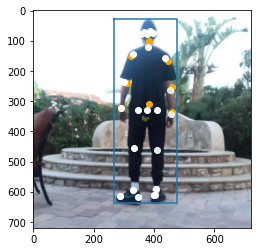

In [72]:
n_frames = world_pose3d.shape[0]
frame_index = np.random.randint(0, n_frames)

imagepath = os.path.join(root, vidname, "images", imagefiles[frame_index])

overlay_visualization(imagepath, keypoints[str(frame_index)], joint2d_proj[frame_index, smpl_7joints_indices], bbox[frame_index])

In [ ]:
### Note that 2d keypoints and overlaid poses may be out of image frames because they are estimated. However, bbox would always be within image boundary.